In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip -qq '/content/drive/MyDrive/Colab Notebooks/DACON/작물병해진단/data/train.zip' -d '/content'
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/DACON/작물병해진단/data/test.zip' -d '/content/test'

# fastAI를 이용한 다중 이미지 분류


## fastai 설치 후 런타임 재시작

In [ ]:
!git clone https://github.com/fastai/fastai
!pip install -e "fastai[dev]"

# !pip install wandb
# !wandb login 37ca933cacc1a97a9d5c5614959b33adb8c00d8d
# 설치후 런타임 재시작! 초기화x

## 필요한 모듈 임포트

In [ ]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

import warnings
warnings.filterwarnings('ignore')

from torchvision import models
from torch.utils.data import Dataset
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score #, precision_recall_fscore_support
# from sklearn.model_selection import train_test_split
from tqdm import tqdm
from fastai.vision.all import *
from fastai.tabular import *

import platform
import sys
import os
import sklearn 
import cv2
import json
from glob import glob
# from shutil import copyfile
from sklearn.model_selection import StratifiedKFold

#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")
print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")
print(f"- pytorch: {torch.__version__}")
print(f"- opencv: {cv2.__version__}")

TRAIN_PATH = '/content/train/'
TEST_PATH = '/content/test/'
SEED = 42
NUM_FOLD = 2
IMG_SIZE = 224

Setup complete. Using torch 1.10.0+cu111 (Tesla P100-PCIE-16GB)
- os: Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic
- python: 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
- pandas: 1.3.5
- numpy: 1.19.5
- sklearn: 1.0.2
- pytorch: 1.10.0+cu111
- opencv: 4.1.2


# 데이터 로드

In [ ]:
def json_data_load(train_json):
    crops = []
    areas = []
    diseases = []
    risks = []
    labels = []
    img_names = []
    parts=[]
    objects = []
    img_w = []
    img_h = []
    grows = []
    img_dirs = []
    for i in range(len(train_json)):
        with open(train_json[i], 'r') as f:
            sample = json.load(f)
            
            crop = sample['annotations']['crop']
            area = sample['annotations']['area']
            disease = sample['annotations']['disease']
            grow = sample['annotations']['grow']
            risk = sample['annotations']['risk']
            label=f"{crop}_{disease}_{risk}"        
            img_name = sample['description']['image'].replace('.jpg','')
            img_dir = train_json[i].replace('.json', '.jpg')
            width = sample['description']['width']
            height = sample['description']['height']

            crops.append(crop)
            areas.append(area)
            diseases.append(disease)
            risks.append(risk)
            labels.append(label)
            img_names.append(img_name)
            img_w.append(width)
            img_h.append(height)
            img_dirs.append(img_dir)
            grows.append(grow)
            r = sample['annotations']['bbox'][0]
            temp = [int(r['x']), int(r['y']), int(r['w']), int(r['h'])]
            objects.append(temp)    
            
            p = []
            
            for part in sample['annotations']['part']:
                p.append([int(part['x']), int(part['y']), int(part['w']), int(part['h'])])
            parts.append(p)

    df = pd.DataFrame({'image':img_names, 'img_w':img_w, 'img_h':img_h, 'crops':crops,'areas':areas,'diseases':diseases,'risks':risks, 
                       'grows':grows, 'bbox':objects, 'parts':parts, 'labels':labels, 'dir':img_dirs})
    df['crop_area'] = df.crops.astype(str) + '_' + df.areas.astype(str)
    df['disease_risk'] = df.diseases.astype(str) + '_' + df.risks.astype(str)

    df['x'] = df.bbox.apply(lambda x: x[0])
    df['y'] = df.bbox.apply(lambda x: x[1])
    df['w'] = df.bbox.apply(lambda x: x[2])
    df['h'] = df.bbox.apply(lambda x: x[3])
    df['xc'] = df.x + df.w.apply(lambda x:x//2)
    df['yc'] = df.y + df.h.apply(lambda x:x//2)
    
    df.dir = df.dir.apply(lambda x: x.replace('\\','/'))
    df = df[['image','crops','areas','diseases','risks','grows','xc','yc','w','h', 'img_w', 'img_h', 'parts', 'dir']]

    return df

In [ ]:
train_csv = sorted(glob(TRAIN_PATH +'*/*.csv'))
train_json = sorted(glob(TRAIN_PATH +'*/*.json'))
test_csv = sorted(glob(TEST_PATH +'*/*.csv'))
df_train = json_data_load(train_json)
df_train['labels'] = df_train.crops.astype(str) + '_' + df_train.diseases.astype(str) + '_' + df_train.risks.astype(str) + '_' + df_train.areas.astype(str)
df_train.labels

0       3_b7_1_3
1       3_00_0_5
2       3_00_0_1
3       3_00_0_3
4       3_00_0_1
          ...   
5762    3_00_0_5
5763    1_00_0_3
5764    2_a5_2_3
5765    1_00_0_3
5766    5_b6_1_3
Name: labels, Length: 5767, dtype: object

In [ ]:
Fold = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=SEED)

for n, (train_index, val_index) in enumerate(Fold.split(df_train.dir, df_train.labels)):
    df_train.loc[val_index, 'fold'] = int(n)
df_train['fold'] = df_train['fold'].astype(int)
train_df = df_train[['dir', 'labels', 'fold']]
train_df

,dir,labels,fold
0,/content/train/10027/10027.jpg,3_b7_1_3,1
1,/content/train/10037/10037.jpg,3_00_0_5,0
2,/content/train/10043/10043.jpg,3_00_0_1,1
3,/content/train/10045/10045.jpg,3_00_0_3,0
4,/content/train/10063/10063.jpg,3_00_0_1,0
...,...,...,...
5762,/content/train/67640/67640.jpg,3_00_0_5,0
5763,/content/train/67644/67644.jpg,1_00_0_3,0
5764,/content/train/67647/67647.jpg,2_a5_2_3,1
5765,/content/train/67649/67649.jpg,1_00_0_3,1


## 점진적  크기 조절
- 크기를 바꿔서 훈련하기 위해 get_dls 함수를 만듦.
- 다중 분류이기 때문에 MultiCategoryBlock사용
- get_x에 이미지 dir이 담긴 Serise를 리턴하는 get_x함수를 전달
- get_y에는 각 이미지에 해당하는 라벨이 담긴 Serise를 리턴하는 get_y함수 전달
- item_tfms: 각 이미지 사이즈를 일괄적으로 리사이징.
  - RandomSizeCrop보다 zeropadding이 더 나은 성능을 보임
  - 잎을 구분할 때 길이 비율이 중요한 정보라고 생각하는데, crop할 경우 그런 정보들을 얻을 수 없어서 그렇다고 추정됨.
  - 또한 병해 특징이 나타나는 부위가 전체가아니라 부분적이기 때문에 crop시 잘려나가면 그런 정보를 학습하지 못해서 성능이 낮아진 것으로 추정

- batch_tfms 매 배치마다 aug_transforms
  - Normalize는 imagenet mean std를 사용하는것 보다 학습이미지의 mean std를 사용하는 것이 더 나은 성능을 보임


In [ ]:
from torchvision.models.efficientnet import efficientnet_b6

set_seed(SEED,True)

def get_x(df): return df['dir']
def get_y(df): return df['labels'].split(' ')

def get_dls(df, bs:int=64, img_size:int=224):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                                splitter=RandomSplitter(seed=SEED),
                                get_x = get_x,
                                get_y = get_y,
                                item_tfms = Resize(320, ResizeMethod.Pad, pad_mode='zeros'), 
                                #RandomResizedCrop(img_size, min_scale=.75) esize(128, ResizeMethod.Pad, pad_mode='zeros') zero 패딩  #RandomResizedCrop(128, min_scale=.35) # 
                                batch_tfms=[*aug_transforms(size=img_size, min_scale=0.75, max_rotate=180, pad_mode='reflection',
                                                            flip_vert=False,max_lighting=0.0, max_warp=0.0,p_affine=0.0,p_lighting=0.75),Normalize, #mult=2변형정도 설정
                                          ])
                                                  #, Normalize.from_stats(*imagenet_stats)) # 이미지넷 mean std사용할떄
    return dblock.dataloaders(df, bs=bs) 


### 훈련
`get_dls`
- 훈련 이미지 준비

In [ ]:
dls = get_dls(train_df, 32, 224)

`cnn_learner(dls, model, loss_func, metric)`
  - 모델 생성
    - efficientnet_b6 사전훈련모델
    - resnet50을 써봤으나 70~80까지 밖에 성능이 안나옴
    - efficientnet_b6는 이미지로만 91%까지.
  - loss_func 
    - BCEWithLogitsLossFlat
    - LabelsmoothingBCEWithLogitsLossFlat을 써보고 싶었으나 에러가 나서 사용해보지 못함
    - 평가지표 f1 macro


In [ ]:
learn = cnn_learner(dls, efficientnet_b6, loss_func=BCEWithLogitsLossFlat(),
                    metrics=F1ScoreMulti(thresh=0.5,average='macro', sample_weight=None)).to_fp16()

`learn.lr_find()`

- 적당한 learning rate 탐색
  - `3e-3`을 사용. cnn계열에 일반적으로 가장 학습이 잘 되는 lr이라고 한다.

lrs.valley: 0.00363078061491251


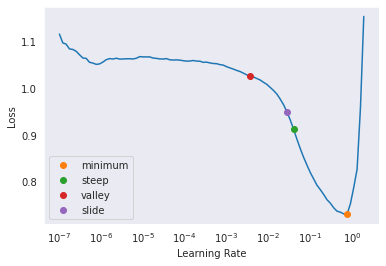

In [ ]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(f'lrs.valley: {lrs.valley}')

In [ ]:
print(f'lrs.minimum: {lrs.minimum}')
print(f'lrs.steep: {lrs.steep}')
print(f'lrs.slide: {lrs.slide}')

lrs.minimum: 0.07585775852203369
lrs.steep: 0.03981071710586548
lrs.slide: 0.02754228748381138


 - `fit_one_cycle`
  - epochs와 lr을 넣어 학습
  - `fine_tune`과 `unfreeze`, `freeze` 사용법은 좀 더 알아봐야할것같다.
  - `lr_max=slice(1e-6,1e-4)`와 같이 유동적인 lr을 사용할 수있다
  - `to_fp16()` : mixed precision
    - 계산효율증가 (https://bo-10000.tistory.com/32)
    - 속도: 1epoch당 1:40초 내외에서 1:20초 내외로 줄어듦.
    - 정확도: 42epoch f1 score 0.87--> 0.90 적은 epoch로 빠르게 수렴

In [ ]:
learn.fit_one_cycle(50, 3e-3)

epoch,train_loss,valid_loss,f1_score,time
0,0.946953,0.690556,0.104448,01:28
1,0.812153,0.563926,0.134615,01:23
2,0.520118,0.276334,0.302264,01:21
3,0.171716,0.065875,0.184491,01:22
4,0.074081,0.039928,0.321315,01:21
5,0.050617,0.030765,0.422685,01:22
6,0.034932,0.022249,0.521666,01:21
7,0.029314,0.018667,0.621721,01:21
8,0.022324,0.017201,0.669596,01:22
9,0.019049,0.014607,0.762976,01:21


`learn.recorder.plot_loss`
-  학습동안의 train/validation loss 그래프 확인

In [ ]:
learn.recorder.plot_loss()

`learn.show_results`
- validation set의 predict 결과를 이미지로 확인할 수 있음

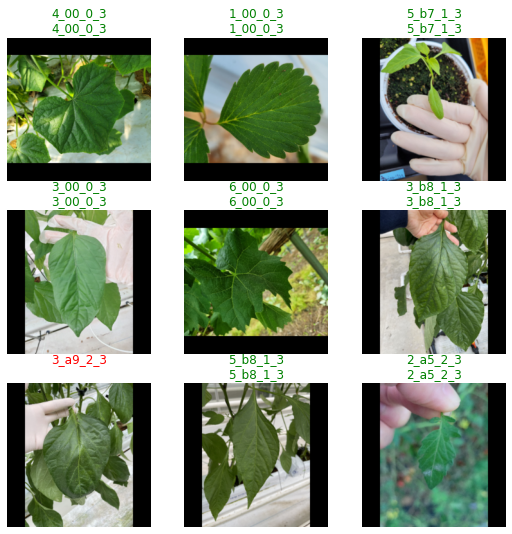

In [ ]:
learn.show_results()

lrs.valley: 0.00363078061491251


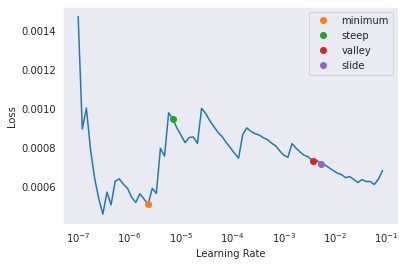

In [ ]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(f'lrs.valley: {lrs.valley}')

- 콜백(cbs)에 early stop callback을 넣으면 조기종료가능 
  - `cbs=EarlyStoppingCallback(monitor='valid', min_delta=0.01, patience=2)`

### 모델 저장 및 불러오기
- `learn.export()`
  - path 지정 후 .pkl 확장자로 모델 저장

In [ ]:
if 'google.colab' in str(get_ipython()):
    temp_path = Path('/content/drive/MyDrive/Colab Notebooks/fastai_models/')
else:
    temp_path = Path(os.getcwd())
learn.path = temp_path
learn.export('efficientNetb6_50epochs.pkl')
learn2 = load_learner('/content/drive/MyDrive/Colab Notebooks/fastai_models/efficientNetb6_50epochs.pkl', cpu=False)


- `learn.load`로 모델 불러오기
  - export후 load해서 재훈련하는것은 안되는 것 같다.
  - load할 때 `cpu=False` 설정을 꼭 해주어야 함.

### 추론
- `dls.test_dl`에 `get_image_files({dir})`을 이용하여 테스트 이미지를 전달
- `learn.get_preds`로 추론
- learn.to_fp16()을 해주지 않으면 에러.
- 과적합인것 같아서 `MCDropoutCallback`사용하여 결과를 구해보았으나 콜백 사용하지 않은 것이 더 LB점수 높음.



In [ ]:
test_dsets = dls.test_dl(get_image_files('test/images'))
preds, targs = learn2.to_fp16().get_preds(dl=test_dsets, cbs=MCDropoutCallback)

### 결과를 label로 바꾸기위해

In [ ]:
def get_pred_df(preds):
    temp_df = pd.DataFrame(preds)
    pred_df = temp_df.idxmax(axis=1).apply(lambda x: dls.train.vocab[x])
    pred_df = pd.concat([pred_df, pd.Series(test_dsets.items)],axis=1)
    pred_df.rename(columns={0:'label',1:'image'},inplace=True)
    pred_df = pred_df[['image','label']].sort_values(by='image')
    # pred_df['crops'] = pred_df.label.apply(lambda x: x.split('_')[0])
    # pred_df['diseases'] = pred_df.label.apply(lambda x: x.split('_')[1])
    # pred_df['risks'] = pred_df.label.apply(lambda x: x.split('_')[2])
    # pred_df['grows'] = pred_df.label.apply(lambda x: x.split('_')[3])
    # pred_df['areas'] = pred_df.label.apply(lambda x: x.split('_')[4])
    pred_df.image = pred_df.image.astype(str).apply(lambda x: x.split('/')[-1].replace('.jpg','')).astype(int)
    pred_df.label = pred_df.label.apply(lambda x: '_'.join(x.split('_')[:3]))
    return pred_df

테스트 3번의결과를 병합 f1 score +0.03... 속도와 trade-off 고려하면 안하는게 낫다.

In [ ]:
test_dsets = dls.test_dl(get_image_files('test/images'))

# preds, targs = learn.get_preds(dl=test_dsets)

results = []
for i in range(3):
    preds, targs = learn.get_preds(dl=test_dsets)
    results += [preds]

results_df = pd.DataFrame([results[0].label,results[1].label,results[2].label,]).T

from collections import Counter
results_df['pred']=0
for i in range(len(results_df)):
    results_df.loc[i,'pred'] = Counter(results_df.iloc[i]).most_common(1)[0][0]

results_df =pd.concat([results[0]['image'],results_df['pred']],axis=1)
results_df = results_df[['image','pred']]
results_df = results_df.rename(columns={'pred':'label'})
results_df = results_df.sort_values(by='image')
results_df.to_csv('./submission.csv',index=False)

### confusion_matrix
- 다중분류에는 오류가 있는 듯 하다.;; sklearn에 있는 confusion_matrix를 사용해야 할 듯

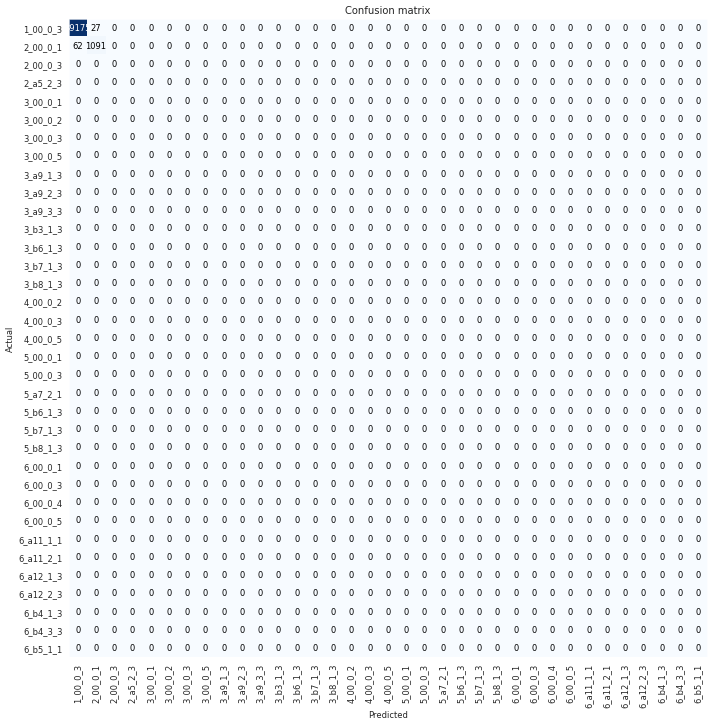

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=10)

[('2_00_0_1', '1_00_0_3', 62), ('1_00_0_3', '2_00_0_1', 27)]

,target,predicted,probabilities,loss
0,5_b6_1_3,5_b8_1_3,"TensorBase([2.7895e-10, 1.9977e-09, 1.8795e-12, 1.1142e-08, 8.9802e-15, 4.4136e-11,\n 1.1929e-09, 2.6055e-09, 7.5507e-12, 2.0936e-09, 1.0203e-09, 7.3914e-11,\n 1.5253e-11, 1.7908e-09, 2.1724e-10, 3.1119e-10, 6.2335e-14, 3.4034e-12,\n 2.4097e-09, 1.0970e-08, 2.7619e-11, 1.0677e-06, 9.1987e-11, 9.9999e-01,\n 3.8346e-11, 1.1496e-08, 1.7456e-10, 8.9157e-11, 2.0007e-12, 3.2107e-10,\n 4.6254e-11, 4.8547e-14, 1.5080e-09, 2.3258e-11, 1.2066e-11])",0.7116075754165649
1,3_a9_3_3,3_a9_2_3,"TensorBase([2.4654e-13, 3.0988e-12, 3.1297e-11, 1.2698e-09, 8.1987e-10, 3.1790e-11,\n 5.3849e-13, 1.0219e-12, 7.8562e-08, 1.0000e+00, 4.6553e-04, 1.9780e-10,\n 3.3698e-13, 6.2598e-12, 2.3426e-15, 1.1287e-13, 3.7808e-14, 3.6436e-13,\n 1.8610e-13, 1.5582e-12, 2.7619e-11, 4.9104e-16, 3.8128e-10, 7.7577e-14,\n 6.8072e-13, 3.9563e-11, 1.7016e-11, 2.0092e-10, 7.1747e-14, 7.4650e-10,\n 1.2397e-13, 2.2801e-13, 7.6697e-12, 1.1514e-11, 9.9462e-11])",0.5924240946769714
2,3_a9_3_3,3_a9_2_3,"TensorBase([9.4764e-08, 3.6535e-08, 7.8562e-08, 9.4764e-08, 5.6910e-09, 2.3860e-10,\n 5.7270e-06, 2.9525e-09, 2.1613e-05, 9.9980e-01, 9.7616e-05, 7.8681e-11,\n 7.8233e-10, 3.8128e-10, 2.2863e-08, 1.8371e-08, 6.2504e-09, 8.5922e-10,\n 1.1744e-09, 1.2430e-08, 3.9504e-08, 3.3789e-08, 6.9728e-09, 6.4759e-07,\n 2.9233e-10, 1.3440e-08, 8.5922e-10, 1.3027e-08, 2.6355e-11, 6.0236e-08,\n 3.1742e-08, 2.6617e-10, 1.6468e-08, 3.0462e-09, 6.6815e-07])",0.507152259349823
3,3_a9_2_3,3_a9_3_3,"TensorBase([1.5827e-12, 5.1600e-11, 2.2542e-11, 2.2637e-09, 2.2733e-07, 5.8717e-09,\n 7.2768e-11, 8.0377e-12, 7.1803e-04, 1.6571e-05, 9.9804e-01, 1.1213e-05,\n 1.1702e-07, 6.8072e-13, 1.2520e-12, 1.6587e-12, 3.6799e-12, 9.4907e-11,\n 9.3435e-11, 1.9585e-11, 1.2186e-10, 1.2790e-13, 4.5278e-10, 1.9810e-13,\n 2.5798e-10, 9.7920e-11, 1.3730e-09, 5.0223e-09, 7.1941e-09, 6.5878e-10,\n 4.1875e-10, 2.1478e-08, 3.1297e-11, 1.6823e-09, 1.2378e-10])",0.49259981513023376
4,3_a9_1_3,3_00_0_3;5_b6_1_3,"TensorBase([1.6894e-07, 1.0572e-07, 2.1478e-08, 2.1145e-08, 2.1145e-08, 2.1234e-06,\n 5.1272e-01, 6.7339e-07, 6.8543e-06, 2.8410e-05, 7.6904e-07, 1.1431e-07,\n 3.7480e-07, 5.6586e-08, 4.1574e-06, 9.5708e-07, 1.3316e-05, 5.3158e-08,\n 3.2563e-07, 1.0130e-05, 1.3232e-08, 9.0414e-01, 3.1316e-07, 6.3522e-05,\n 2.5216e-06, 8.2804e-09, 2.0537e-07, 1.2048e-08, 3.0288e-08, 6.6815e-07,\n 1.9293e-07, 1.0349e-06, 5.9088e-06, 1.4337e-07, 8.8516e-07])",0.42727425694465637
5,3_b6_1_3,3_b8_1_3,"TensorBase([3.4394e-07, 1.6212e-08, 2.7421e-07, 5.6705e-07, 4.1164e-07, 5.2334e-08,\n 1.0953e-05, 4.5729e-09, 1.5356e-04, 2.7752e-05, 1.3873e-04, 4.8485e-03,\n 3.6195e-05, 5.8505e-07, 9.8615e-01, 7.4965e-08, 9.2374e-09, 2.2911e-07,\n 1.0511e-06, 6.6916e-10, 2.0062e-07, 1.0800e-08, 2.4967e-07, 2.5907e-08,\n 1.7062e-06, 3.8891e-08, 3.4663e-07, 5.5709e-08, 1.6028e-06, 7.6305e-07,\n 1.5057e-06, 3.7853e-06, 4.7010e-07, 5.5709e-08, 2.7479e-06])",0.41461077332496643


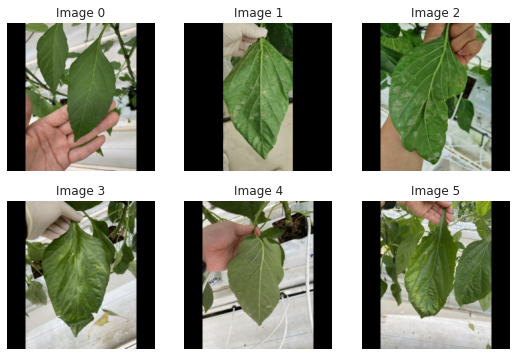

In [ ]:
interp.plot_top_losses(6, nrows=2)

- 3_a9_3, 3_a9_2
- 5_b6_1_3, 5_b8_1_3
- 다량원소 결핍 시리즈를 가장 어려워 한다.

## 그 외 시도해 본 것

### CutMix, MixUp
- 두가지 모두 80epochs 이상 훈련해야 성능 개선을 기대할 수 있다고 함.
- 100epochs 까지 해봤는데, 같은 epoch에서 적용하지 않은 모델보다 성능이 떨어져서 시간상 더이상 훈련해보지 않았다.
- labelsmoothingLoss종류를 사용해보고 싶었으나 shape 오류로 사용해보지 못했는데 Flat을 사용해도 왜 오류가 나는지 모르겠다. 

### 라벨 변경
- 라벨에 grows까지 넣어서 훈련. 생육단계마다 작물의 형태가 다르므로 생육단계별로도 구별하게 되면 성능이 높아지지 않을까 해서 라벨링을 다르게 해보았는데 오히려 떨어짐

### crops-areas / diseases-risks 를 나누어 훈련
- 따로 훈련한 두 개의 모델의 결과를 병합해 제출해보았는데 훈련에 없는 새로운 라벨들이 나오게 되어서 점수 하락
  - private 2위 코드를 보고서야 뭘 잘못했는지 깨달았다!
